# 1. Load the libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import glob
import numpy as np
import pandas as pd  
from PIL import Image
from skimage import measure
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import tensorflow as tf
from skimage.measure import label, regionprops, regionprops_table

2024-12-10 11:31:11.053067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 11:31:11.981230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. EfficientNetB0

## 2.1 Load the model

In [2]:
#define the file paths for the images and corresponding masks
image_path = '/4tbint/Corrected Merged FOVs/Set3/20210318_N1Set25__2021-03-18T11_28_37-Measurement 1'
mask_path = '/4tbint/Cellpose Masks/Set3/20210318_N1Set25__2021-03-18T11_28_37-Measurement 1'

#use the glob library to generate lists of image and mask filenames
images =  sorted([os.path.basename(x) for x in glob.glob(image_path + '/*.tiff')])
cellpose_mask = sorted([os.path.basename(x) for x in glob.glob(mask_path + '/*.tiff')])

ch1 = []
ch2 = []
ch4 = []

for i in range(0, 1152, 3):
    
    CH1_path = os.path.join(image_path, images[i])
    CH2_path = os.path.join(image_path, images[i+1])
    CH4_path = os.path.join(image_path, images[i+2])
 
    #read images and masks using the Image library, and converts them to numpy arrays.
    ch1_img = Image.open(CH1_path)
    ch2_img = Image.open(CH2_path)
    ch4_img = Image.open(CH4_path)

    ch1.append(np.array(ch1_img))
    ch2.append(np.array(ch2_img))
    ch4.append(np.array(ch4_img))

ch1_max = np.max(ch1)
ch2_max = np.max(ch2)
ch4_max = np.max(ch4)
print("Maximum intensity for channel 1:", ch1_max)
print("Maximum intensity for channel 2:", ch2_max)
print("Maximum intensity for channel 4:", ch4_max)

ch1_q099 =  np.quantile(ch1, 0.99)
ch2_q099 =  np.quantile(ch2, 0.99)
ch4_q099 =  np.quantile(ch4, 0.99)
print("Quantile_099 channel 1:", ch1_q099)
print("Quantile_099 channel 2:", ch2_q099)
print("Quantile_099 channel 4:", ch4_q099)

Maximum intensity for channel 1: 64617
Maximum intensity for channel 2: 65535
Maximum intensity for channel 4: 65347
Quantile_099 channel 1: 3339.0
Quantile_099 channel 2: 2640.0
Quantile_099 channel 4: 5382.0


## 2.3 Read images as tensors and extract features

In [49]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def preprocess_image(image):
    image = tf.image.resize(image, (50, 50))
    image = preprocess_input(image)
    return image

# Define paths
image_path = '/4tbint/Corrected Merged FOVs/Set3/20210318_N1Set25__2021-03-18T11_28_37-Measurement 1'
mask_path = '/4tbint/Cellpose Masks/Set3/20210318_N1Set25__2021-03-18T11_28_37-Measurement 1'

# Define the specific image we want to process
image_name = 'r01c01'

# Load images
image_array_ch1 = np.array(Image.open(os.path.join(image_path, f'{image_name}ch1.tiff')))
image_array_ch2 = np.array(Image.open(os.path.join(image_path, f'{image_name}ch2.tiff')))
image_array_ch4 = np.array(Image.open(os.path.join(image_path, f'{image_name}ch4.tiff')))

# Load Cellpose mask
cellpose_img = np.array(Image.open(os.path.join(mask_path, f'{image_name}ch2.tiff')))
masks_ch2 = np.array(cellpose_img)


labels_ch2 = label(masks_ch2)

props = regionprops(labels_ch2)

single_cell_bbox = []

for cell_label, target_region in enumerate(props, start=1):
    centroid_row, centroid_col = target_region.centroid
    
    half_size = 45
    min_row = int(max(centroid_row - half_size, 0))
    max_row = int(min(centroid_row + half_size, image_array_ch2.shape[0]))
    min_col = int(max(centroid_col - half_size, 0))
    max_col = int(min(centroid_col + half_size, image_array_ch2.shape[1]))
    
    if (min_row > 0 and max_row < image_array_ch2.shape[0] and 
    min_col > 0 and max_col < image_array_ch2.shape[1]):
    
        target_cell_mask = labels_ch2 == cell_label
    
        cell_area_original = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch2[min_row:max_row, min_col:max_col], 0)
    
        empty_array_ch2 = np.zeros((90, 90))
        paste_row_original = (90 - cell_area_original.shape[0]) // 2
        paste_col_original = (90 - cell_area_original.shape[1]) // 2
    
        empty_array_ch2[paste_row_original:paste_row_original+cell_area_original.shape[0], paste_col_original:paste_col_original+cell_area_original.shape[1]] = cell_area_original
    
        empty_array_cellpose = np.zeros((90, 90))
        cell_area_cellpose = target_cell_mask[min_row:max_row, min_col:max_col]

        paste_row_cellpose = (90 - cell_area_cellpose.shape[0]) // 2
        paste_col_cellpose = (90 - cell_area_cellpose.shape[1]) // 2

        empty_array_cellpose[paste_row_cellpose:paste_row_cellpose+cell_area_cellpose.shape[0], paste_col_cellpose:paste_col_cellpose+cell_area_cellpose.shape[1]] = cell_area_cellpose

        cell_area_ch1 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch1[min_row:max_row, min_col:max_col], 0)
        cell_area_ch4 = np.where(target_cell_mask[min_row:max_row, min_col:max_col], image_array_ch4[min_row:max_row, min_col:max_col], 0)

        empty_array_ch1 = np.zeros((90, 90))
        paste_row_ch1 = (90 - cell_area_ch1.shape[0]) // 2
        paste_col_ch1 = (90 - cell_area_ch1.shape[1]) // 2

        empty_array_ch4 = np.zeros((90, 90))
        paste_row_ch4 = (90 - cell_area_ch4.shape[0]) // 2
        paste_col_ch4 = (90 - cell_area_ch4.shape[1]) // 2

        empty_array_ch1[paste_row_ch1:paste_row_ch1+cell_area_ch1.shape[0], paste_col_ch1:paste_col_ch1+cell_area_ch1.shape[1]] = cell_area_ch1
        empty_array_ch4[paste_row_ch4:paste_row_ch4+cell_area_ch4.shape[0], paste_col_ch4:paste_col_ch4+cell_area_ch4.shape[1]] = cell_area_ch4
        empty_array_ch1 = (empty_array_ch1.astype('float32')/ch1_q099)*255
        empty_array_ch2 = (empty_array_ch2.astype('float32')/ch2_q099)*255
        empty_array_ch4 = (empty_array_ch4.astype('float32')/ch4_q099)*255

        singlecell = np.stack((empty_array_ch1, empty_array_ch2, empty_array_ch4), axis=-1)
        reshaped_singlecell = singlecell.reshape((90,90,3))
        single_cell_bbox.append(reshaped_singlecell)
'''
labels = label(masks_ch2)
regions = measure.regionprops(labels)
j=0

j=j+1
single_cell_bbox = []

for props in regions:
    y0, x0 = props.centroid
    y = int(round(y0))
    x = int(round(x0))
    box_ch1 = image_array_ch1[x-45:x+45,y-45:y+45]
    box_ch2 = image_array_ch2[x-45:x+45,y-45:y+45]
    box_ch4 = image_array_ch4[x-45:x+45,y-45:y+45]

    if (box_ch1.shape == (90,90)):
        coordinate = x, y
        
        box_ch1 = (box_ch1.astype('float32')/ch1_q099)*255
        box_ch2 = (box_ch2.astype('float32')/ch2_q099)*255
        box_ch4 = (box_ch4.astype('float32')/ch4_q099)*255
        
        singlecell = np.stack((box_ch1, box_ch2, box_ch4), axis=-1)
        reshaped_singlecell = singlecell.reshape((1,90,90,3))
        single_cell_bbox.append(reshaped_singlecell)

single_cells = np.array(single_cell_bbox)
'''

"\nlabels = label(masks_ch2)\nregions = measure.regionprops(labels)\nj=0\n\nj=j+1\nsingle_cell_bbox = []\n\nfor props in regions:\n    y0, x0 = props.centroid\n    y = int(round(y0))\n    x = int(round(x0))\n    box_ch1 = image_array_ch1[x-45:x+45,y-45:y+45]\n    box_ch2 = image_array_ch2[x-45:x+45,y-45:y+45]\n    box_ch4 = image_array_ch4[x-45:x+45,y-45:y+45]\n\n    if (box_ch1.shape == (90,90)):\n        coordinate = x, y\n        \n        box_ch1 = (box_ch1.astype('float32')/ch1_q099)*255\n        box_ch2 = (box_ch2.astype('float32')/ch2_q099)*255\n        box_ch4 = (box_ch4.astype('float32')/ch4_q099)*255\n        \n        singlecell = np.stack((box_ch1, box_ch2, box_ch4), axis=-1)\n        reshaped_singlecell = singlecell.reshape((1,90,90,3))\n        single_cell_bbox.append(reshaped_singlecell)\n\nsingle_cells = np.array(single_cell_bbox)\n"

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load the pretrained EfficientNetB0 model and image
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(90, 90, 3))

input_array = np.expand_dims(single_cell_bbox, axis=0)
input_array = input_array.reshape((-1, 90, 90, 3))
input_array = input_array[0:1]  # Shape: (5, 90, 90, 3)

# Step 2: Extract intermediate outputs
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name or 'block' in layer.name]
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Step 3: Generate activation maps
activations = activation_model.predict(input_array)
'''
def plot_activation_maps(activations, col_size=6, row_size=6):
    for layer_idx, activation in enumerate(activations):
        # Skip layers with non-spatial outputs (e.g., 2D tensors)
        if len(activation.shape) != 4:
            print(f"Skipping Layer {layer_idx + 1}: Activation is {len(activation.shape)}-dimensional")
            continue

        num_filters = activation.shape[-1]
        size = activation.shape[1]  # Assuming square activation maps
        grid_cols = col_size
        grid_rows = row_size if row_size * col_size >= num_filters else num_filters // col_size + 1

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))
        fig.suptitle(f'Layer {layer_idx + 1}: Activation Maps', fontsize=16)

        for i in range(grid_rows * grid_cols):
            ax = axes[i // grid_cols, i % grid_cols]
            if i < num_filters:
                ax.imshow(activation[0, :, :, i], cmap='viridis')
                ax.axis('off')
            else:
                ax.remove()

        plt.tight_layout()
        plt.show()


# Visualize activations for all layers
plot_activation_maps(activations)
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


'\ndef plot_activation_maps(activations, col_size=6, row_size=6):\n    for layer_idx, activation in enumerate(activations):\n        # Skip layers with non-spatial outputs (e.g., 2D tensors)\n        if len(activation.shape) != 4:\n            print(f"Skipping Layer {layer_idx + 1}: Activation is {len(activation.shape)}-dimensional")\n            continue\n\n        num_filters = activation.shape[-1]\n        size = activation.shape[1]  # Assuming square activation maps\n        grid_cols = col_size\n        grid_rows = row_size if row_size * col_size >= num_filters else num_filters // col_size + 1\n\n        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 15))\n        fig.suptitle(f\'Layer {layer_idx + 1}: Activation Maps\', fontsize=16)\n\n        for i in range(grid_rows * grid_cols):\n            ax = axes[i // grid_cols, i % grid_cols]\n            if i < num_filters:\n                ax.imshow(activation[0, :, :, i], cmap=\'viridis\')\n                ax.axis(\'off\'

## Unfiltered bounding box

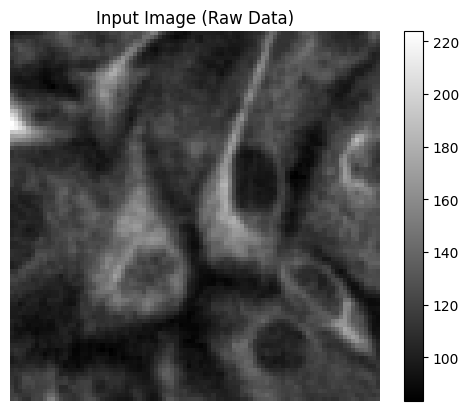

In [35]:
import matplotlib.pyplot as plt

input_array = np.expand_dims(single_cell_bbox, axis=0)
input_array = input_array.reshape((-1, 90, 90, 3))
input_array = input_array[176:177]  # Shape: (5, 90, 90, 3)
im = input_array[0]  # Shape becomes (90, 90, 3)

plt.imshow(im[:,:,1], cmap= 'gray')
plt.colorbar()
plt.axis("off")
plt.title("Input Image (Raw Data)")
plt.show()

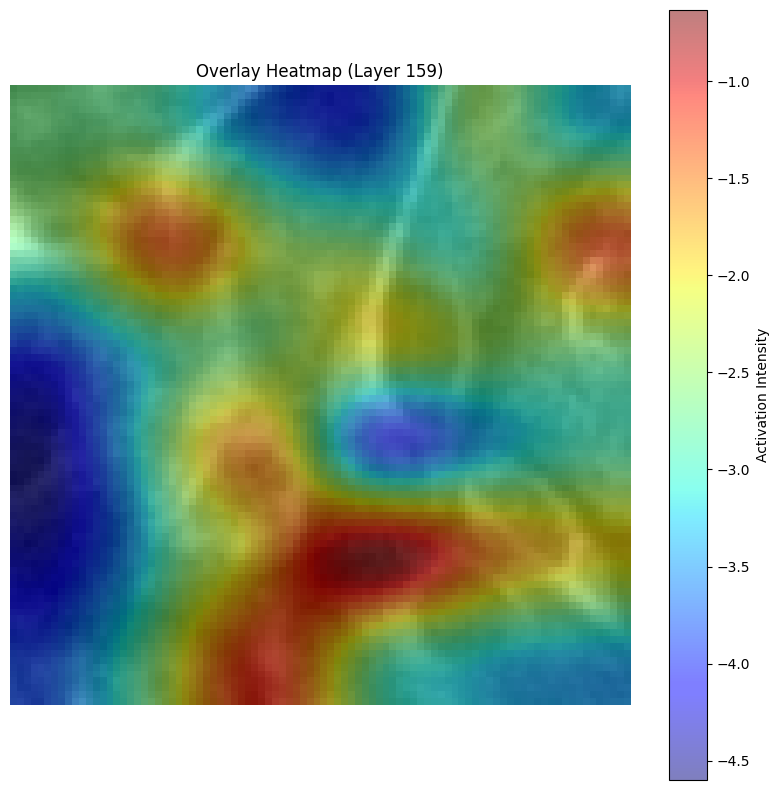

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def normalize_activation_map(activation_map):
    """Normalize activation map to range 0-1."""
    return (activation_map - np.min(activation_map)) / (np.max(activation_map) - np.min(activation_map) + 1e-10)

# Ensure the layer index is valid
layer_index = 158  # Adjust for zero-based indexing

if layer_index < len(activations):
    activation = activations[layer_index]  # Activation output for the specific layer
    if len(activation.shape) == 4:  # Ensure it's a spatial output
        activation_map = activation[0, :, :, 70]  # First filter's activation map
        upsampled_map = cv2.resize(activation_map, (90, 90), interpolation=cv2.INTER_CUBIC)

       # Prepare input image
        input_array = np.expand_dims(single_cell_bbox, axis=0)
        input_array = input_array.reshape((-1, 90, 90, 3))
        input_array = input_array[176:177]
        im = input_array[0]  # Shape becomes (90, 90, 3)

        # Normalize input image for visualization
        normalized_image = normalize_activation_map(im)

        # Plot the results
        plt.figure(figsize=(10, 10))

        # Show input image
        plt.imshow(normalized_image[:, :, 1], cmap='gray', interpolation='nearest')  # Use the second channel
        plt.axis('off')

        # Overlay activation map as heatmap
        plt.imshow(upsampled_map, cmap='jet', alpha=0.5, interpolation='nearest')  # Heatmap with transparency
        plt.colorbar(label="Activation Intensity")
        plt.title(f"Overlay Heatmap (Layer {layer_index + 1})")

        plt.show()
    else:
        print(f"Layer {layer_index + 1} does not have spatial output; skipping visualization.")
else:
    print(f"Layer index {layer_index + 1} is out of range.")


## filtered bounding box

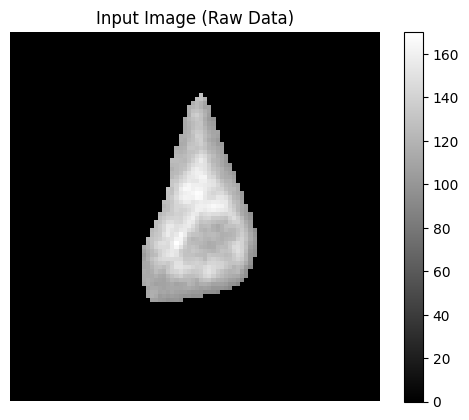

In [54]:
import matplotlib.pyplot as plt

input_array = np.expand_dims(single_cell_bbox, axis=0)
input_array = input_array.reshape((-1, 90, 90, 3))
input_array = input_array[0:1]  # Shape: (5, 90, 90, 3)
im = input_array[0]  # Shape becomes (90, 90, 3)

plt.imshow(im[:,:,1], cmap= 'gray')
plt.colorbar()
plt.axis("off")
plt.title("Input Image (Raw Data)")
plt.show()

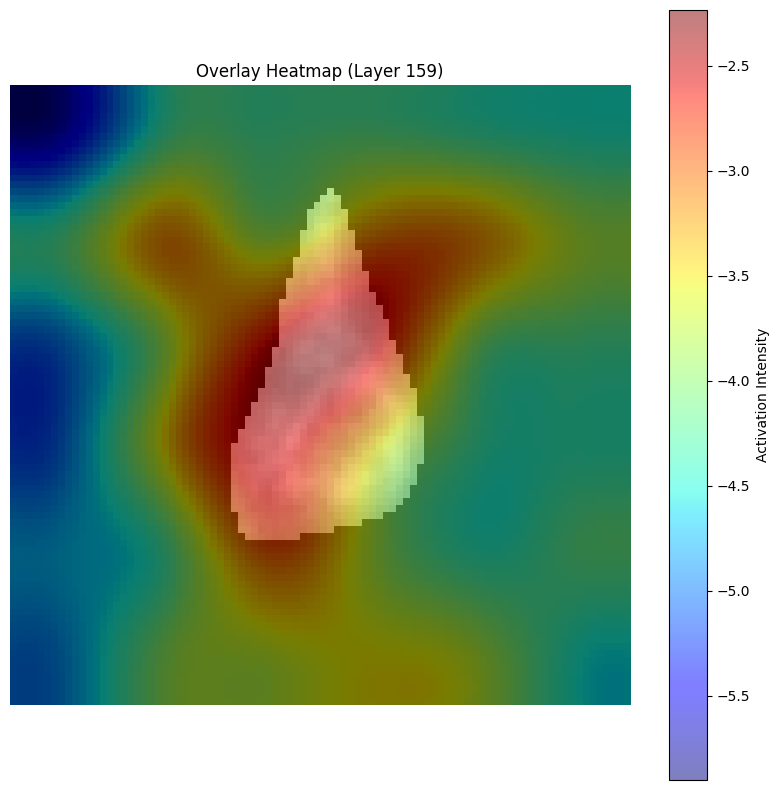

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def normalize_activation_map(activation_map):
    """Normalize activation map to range 0-1."""
    return (activation_map - np.min(activation_map)) / (np.max(activation_map) - np.min(activation_map) + 1e-10)

# Ensure the layer index is valid
layer_index = 158  # Adjust for zero-based indexing

if layer_index < len(activations):
    activation = activations[layer_index]  # Activation output for the specific layer
    if len(activation.shape) == 4:  # Ensure it's a spatial output
        activation_map = activation[0, :, :, 70]  # First filter's activation map
        upsampled_map = cv2.resize(activation_map, (90, 90), interpolation=cv2.INTER_CUBIC)

        # Prepare input image
        input_array = np.expand_dims(single_cell_bbox, axis=0)
        input_array = input_array.reshape((-1, 90, 90, 3))
        input_array = input_array[0:1]
        im = input_array[0]  # Shape becomes (90, 90, 3)

        # Normalize input image for visualization
        normalized_image = normalize_activation_map(im)

        # Plot the results
        plt.figure(figsize=(10, 10))

        # Show input image
        plt.imshow(normalized_image[:, :, 1], cmap='gray', interpolation='nearest')  # Use the second channel
        plt.axis('off')

        # Overlay activation map as heatmap
        plt.imshow(upsampled_map, cmap='jet', alpha=0.5, interpolation='nearest')  # Heatmap with transparency
        plt.colorbar(label="Activation Intensity")
        plt.title(f"Overlay Heatmap (Layer {layer_index + 1})")

        plt.show()
    else:
        print(f"Layer {layer_index + 1} does not have spatial output; skipping visualization.")
else:
    print(f"Layer index {layer_index + 1} is out of range.")
